In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
!pip install pmdarima
import pmdarima as pm

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.5 MB 905 kB/s 


In [2]:
df = pd.read_csv('/kaggle/input/electric-production/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.index = df['DATE']
df

,DATE,Value
DATE,,
1985-01-01,1985-01-01,72.5052
1985-02-01,1985-02-01,70.6720
1985-03-01,1985-03-01,62.4502
1985-04-01,1985-04-01,57.4714
1985-05-01,1985-05-01,55.3151
...,...,...
2017-09-01,2017-09-01,98.6154
2017-10-01,2017-10-01,93.6137
2017-11-01,2017-11-01,97.3359


Text(0.5, 1.0, 'Value')

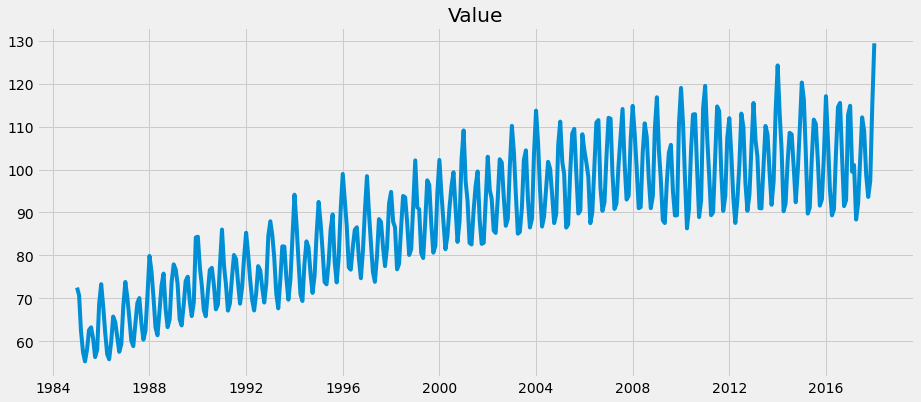

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df['Value'])
plt.title('Value')

The series is cyclical, has a trend. I assume that this is a multiplicative scheme F*C*S*E, since in recent years one can observe an expansion of the cycle span

In [4]:
#I check whether there is a violation of the sequence of the series
(df['DATE'].shift(1) - df['DATE']).value_counts()

-31 days    231
-30 days    132
-28 days     25
-29 days      8
Name: DATE, dtype: int64

In [5]:
#There are no omissions, and all types are given
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.3 KB


##  Lags and Linear Model on Time Series

### Feature Engineering

In [6]:
df_lags = df.copy()
df_lags = (df_lags.set_index(df['DATE'], drop=True)).drop('DATE', axis=1)

for i in range(1, 13):
    df_lags['Value_{}'.format(i)] = df_lags['Value'].shift(i)
df_lags.tail()

,Value,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,Value_8,Value_9,Value_10,Value_11,Value_12
DATE,,,,,,,,,,,,,
2017-09-01,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637
2017-10-01,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867
2017-11-01,97.3359,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900
2017-12-01,114.7212,97.3359,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694
2018-01-01,129.4048,114.7212,97.3359,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505


In [7]:
df_lags_and_dt = df_lags.copy()
df_lags_and_dt['month'] = df_lags_and_dt.index.month
df_lags_and_dt['year'] = df_lags_and_dt.index.year
df_lags_and_dt

,Value,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,Value_8,Value_9,Value_10,Value_11,Value_12,month,year
DATE,,,,,,,,,,,,,,,
1985-01-01,72.5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1985
1985-02-01,70.6720,72.5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1985
1985-03-01,62.4502,70.6720,72.5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1985
1985-04-01,57.4714,62.4502,70.6720,72.5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1985
1985-05-01,55.3151,57.4714,62.4502,70.6720,72.5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-01,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637,9,2017
2017-10-01,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,10,2017
2017-11-01,97.3359,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,11,2017


<AxesSubplot:xlabel='DATE'>

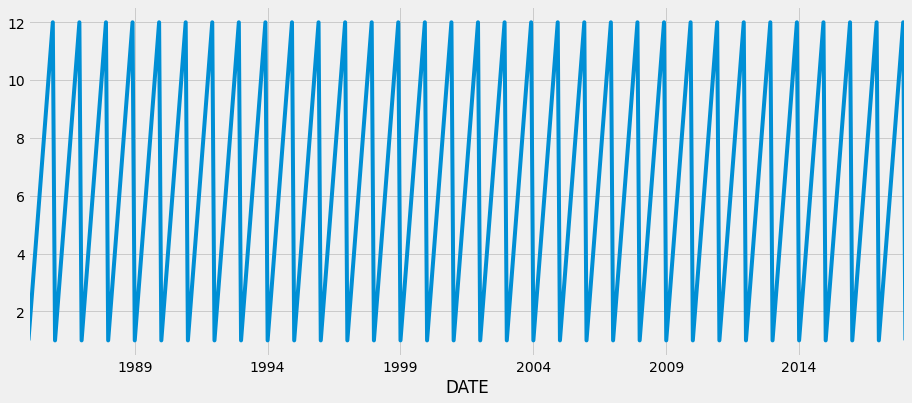

In [8]:
plt.figure(figsize=(14, 6))
df_lags_and_dt['month'].plot()

<AxesSubplot:>

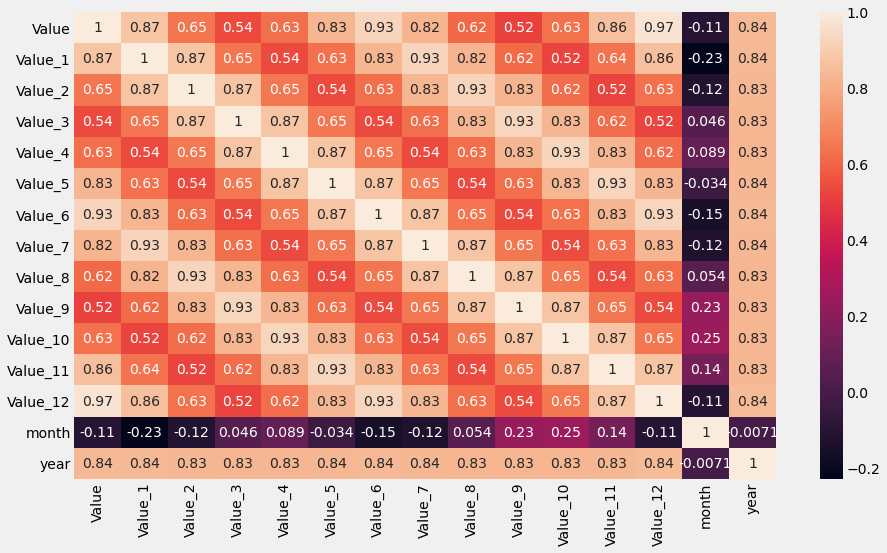

In [9]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_lags_and_dt.corr(), annot=True)

### Building Ridge and Lasso Regressions

First, initialize the functions for the prediction visualization

In [10]:
def  plotModelResults(y_test, prediction, model, intervals=False, anomalies=False):
    """
    The function receives the predicted value and true values as input and then builds
    graphs, comparing them. Builds confidence intervals if necessary
    and points of abnormal values.
    """
    
    plt.figure(figsize=(20, 6))
    #plt.plot(y_train)
    plt.plot(y_test, color='red', linewidth=4, label='test')
    plt.plot(y_test.index, prediction, color='blue',linewidth=3, label='prediction')
    
    if intervals==True:
        cv = cross_val_score(model, X_train, y_train, 
                                            cv=tscv, 
                                            scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(y_test.index, lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(y_test.index, upper, "r--", alpha=0.5)
        
        if anomalies==True:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(y_test.index, anomalies, "o", markersize=10, label = "Anomalies")

    plt.legend(loc="best")
    plt.title("Mean absolute percentage error: {} %".format(round(mean_absolute_percentage_error(y_test, prediction), 2)))
    
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')

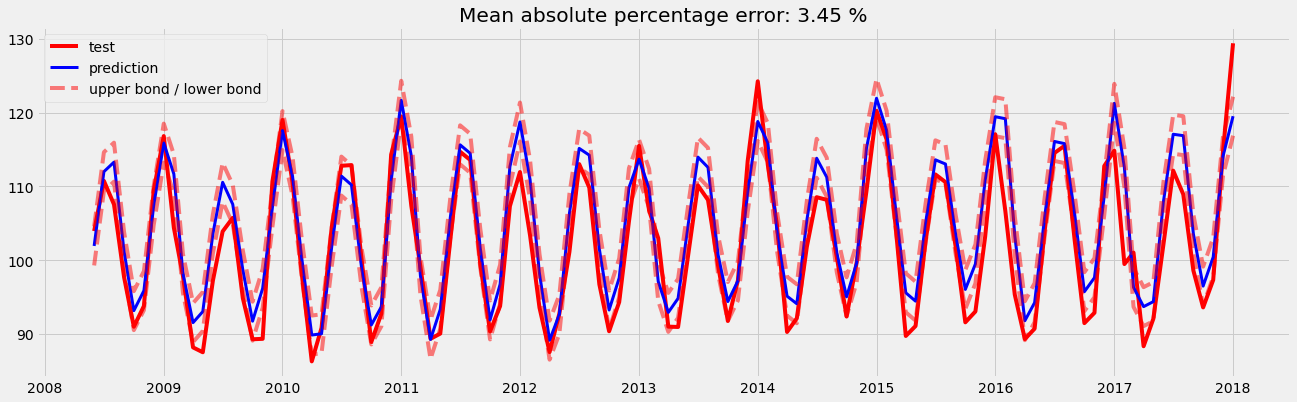

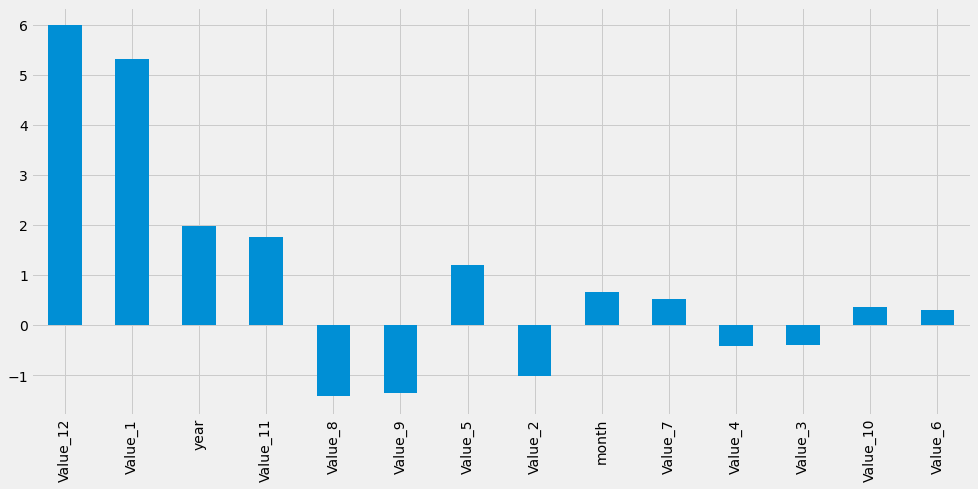

In [11]:
tscv = TimeSeriesSplit(n_splits=5)
def split_train_test(X, y, test_size):
    
    train_size = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]    
    X_test = X.iloc[train_size:]
    y_test = y.iloc[train_size:]
    
    return X_train, X_test, y_train, y_test

tscv = TimeSeriesSplit(n_splits=5)

X = df_lags_and_dt.dropna().drop('Value', axis=1)
y = df_lags_and_dt.dropna()['Value']

X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3)

scaler = StandardScaler()
X_train[X.columns] =  scaler.fit_transform(X_train)
X_test[X.columns] = scaler.transform(X_test)


ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.5, 10))
ridge.fit(X_train, y_train)
prediction = ridge.predict(X_test)

plotModelResults(y_test, prediction=prediction, model=ridge, intervals=True)
plotCoefficients(ridge)

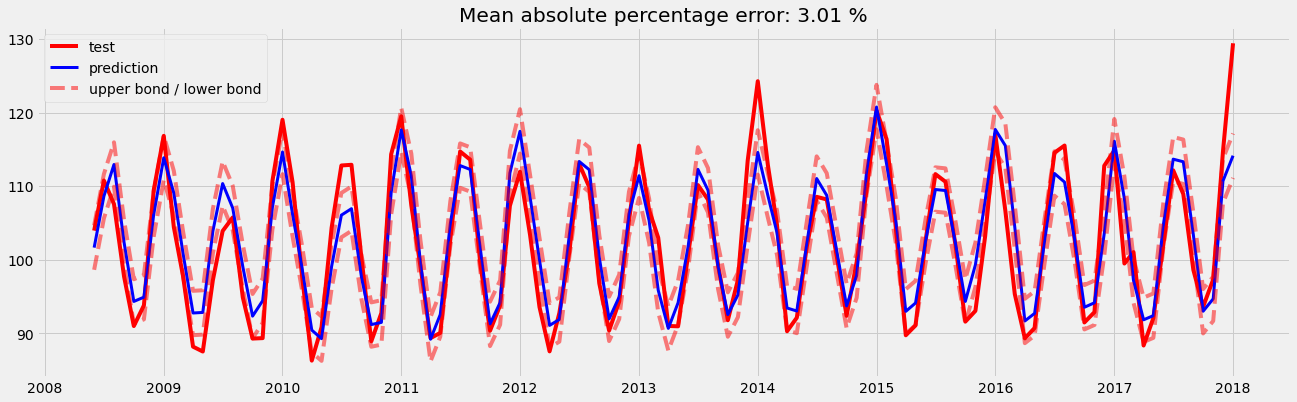

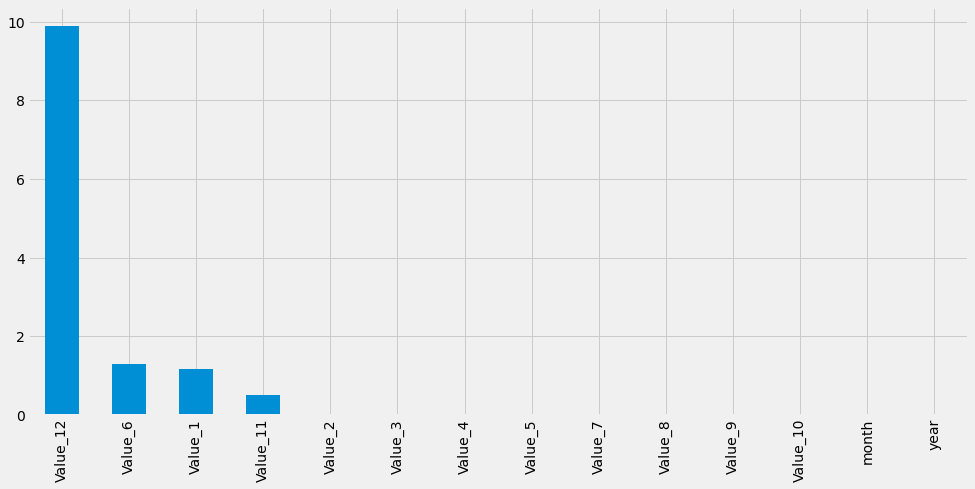

In [12]:
lasso = LassoCV(cv=tscv, alphas=np.linspace(0.5, 10))
lasso.fit(X_train, y_train)
prediction = lasso.predict(X_test)

plotModelResults(y_test, prediction=prediction, model=lasso, intervals=True)
plotCoefficients(lasso)

You can see that Lasso regression performed better. In addition, there was a strong dependence on the year and on the 12 and 1 shifts

### Let's Boosting

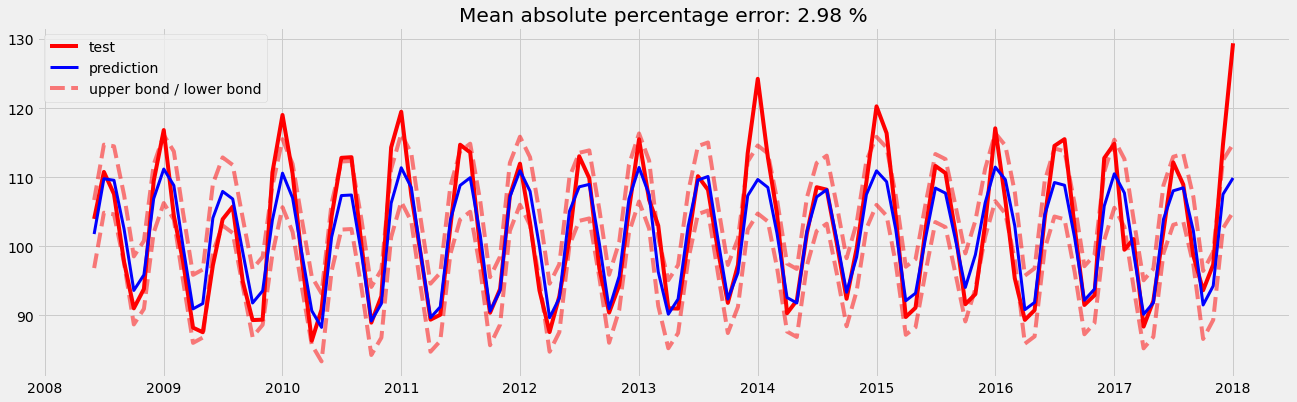

In [13]:
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1,
                          loss_function='RMSE', verbose=0)
catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)

plotModelResults(y_test, prediction=prediction, model=catboost, intervals=True)

The Lasso linear model does a better job of predicting data. Boosting models unnecessarily average predictions.

### SARIMA

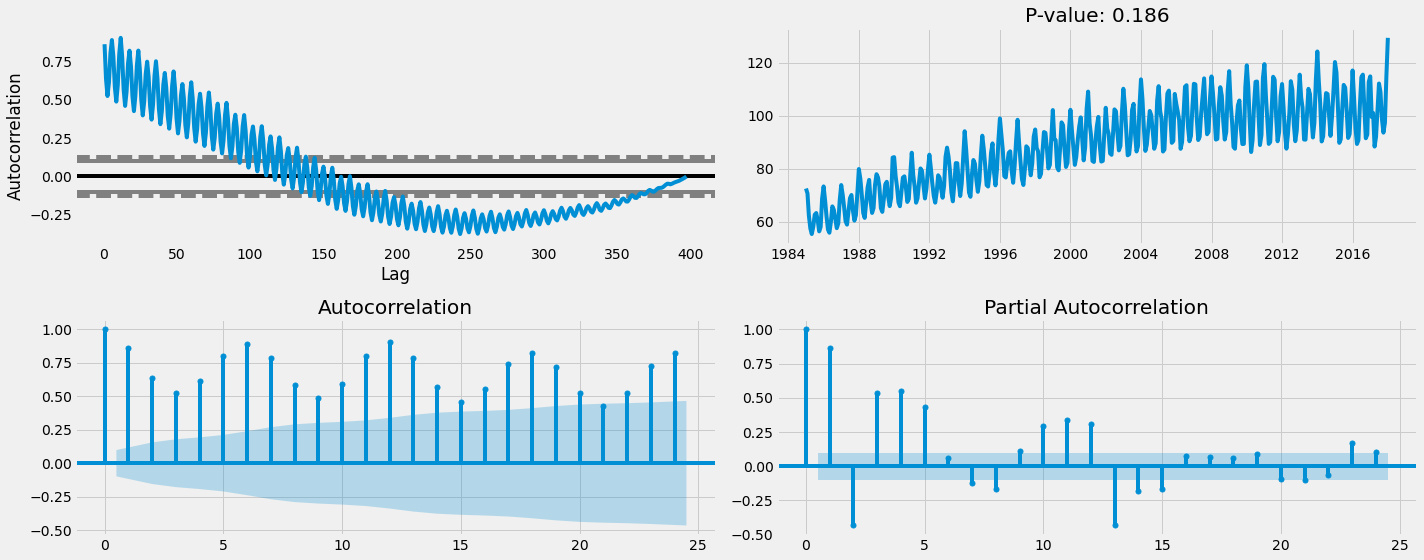

In [14]:
def stat_all_corr(y, lags):
    fig, ax = plt.subplots(2, 2)
    plt.subplots_adjust(hspace=0.2)
    fig.set_size_inches(20, 8)

    autocorrelation_plot(y, ax=ax[0, 0])
    
    ax[0, 1].plot(y)
    ax[0, 1].set_title("P-value: {}".format(round(sm.tsa.stattools.adfuller(y)[1], 3)))
    
    smt.graphics.plot_acf(y, lags=lags, ax=ax[1,0])
    smt.graphics.plot_pacf(y, lags=lags, ax=ax[1, 1])
    
    plt.tight_layout()
    
stat_all_corr(df['Value'], lags=24)

In [15]:
#The variance of the series increases every year
df.groupby(df.index.year)['Value'].var()

DATE
1985     33.023561
1986     28.274668
1987     23.604905
1988     35.883170
1989     36.649961
1990     30.400162
1991     31.003358
1992     34.624594
1993     43.338446
1994     54.391067
1995     48.459738
1996     53.149963
1997     52.323712
1998     39.562748
1999     56.565680
2000     51.720546
2001     68.059271
2002     43.891374
2003     76.417231
2004     72.711687
2005     81.069754
2006     63.319716
2007     70.672342
2008     74.080783
2009     91.794044
2010    126.894955
2011    107.119589
2012     75.854864
2013     74.427694
2014     95.940330
2015    105.377955
2016    111.647808
2017     79.408260
2018           NaN
Name: Value, dtype: float64

In [16]:
#I highlight the trend and seasonality
decomp = seasonal_decompose(df['Value'], model='additive', extrapolate_trend='freq')
df['Trend'] = decomp.trend
df['Seasonal'] = decomp.seasonal

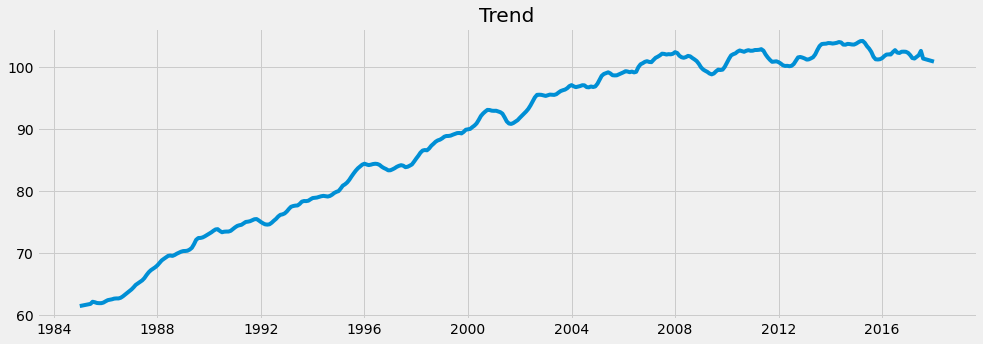

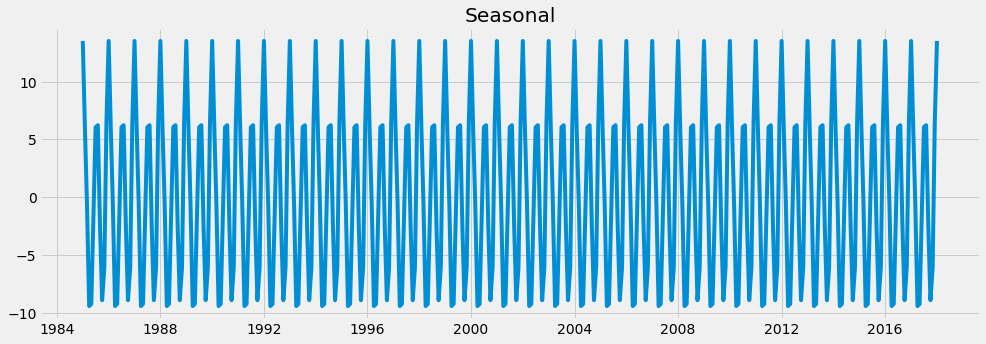

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df['Trend'])
plt.title('Trend')
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Seasonal')
plt.plot(df['Seasonal'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

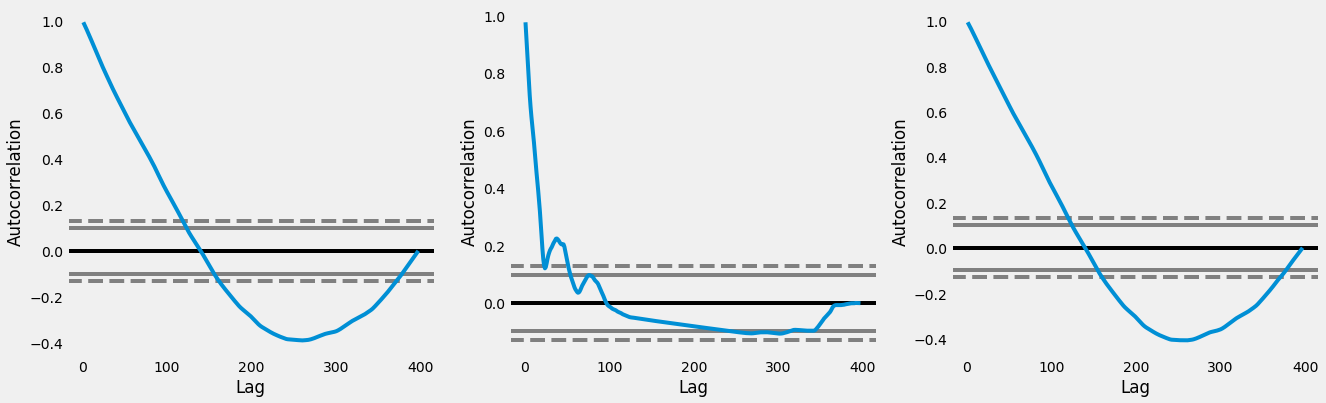

In [18]:
#I want to know if the trend is linear or not linear. This is necessary to choose a growth curve that is better suited to the nature of the trend.
df['Trend_log'] = np.log(df['Trend'])
df['Trend_exp'] = np.exp(df['Trend'])

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 6)
autocorrelation_plot(df['Trend_log'], ax=ax[0])
autocorrelation_plot(df['Trend_exp'], ax=ax[1])
autocorrelation_plot(df['Trend'], ax=ax[2])

### Transforming

The series is non-stationary and has seasonality. Hence it needs to be transformed, the first thing I will try is logarithm

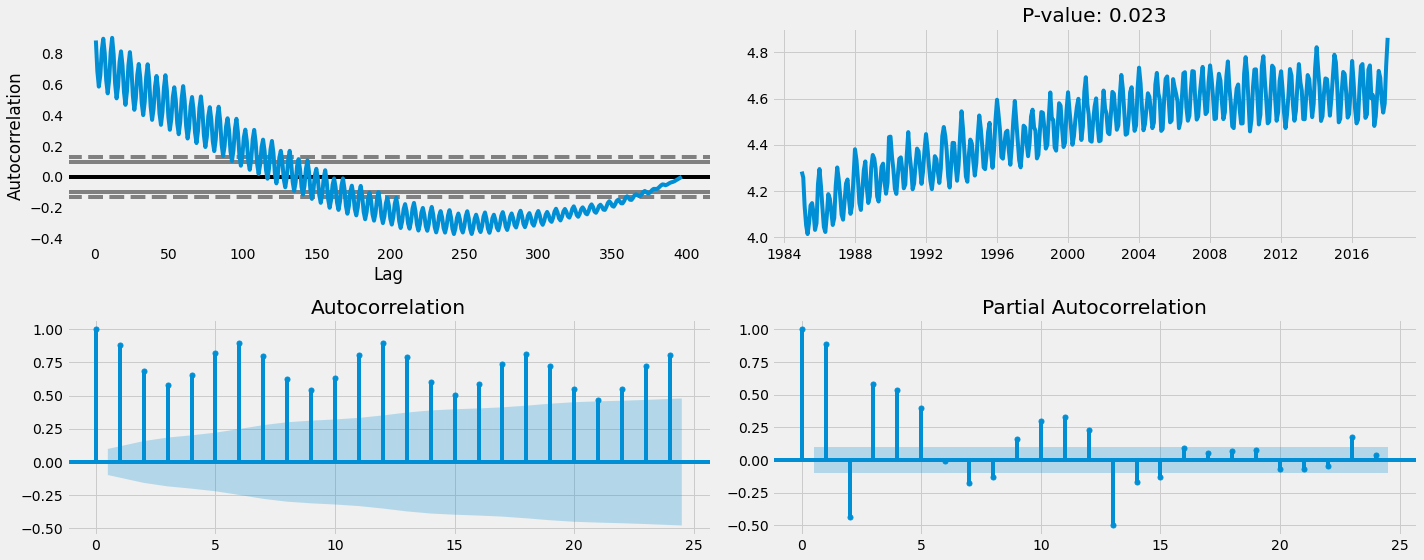

In [19]:
#The changes are not significant, the seasonality and the trend has remained
df['Value_log'] = np.log(abs(df['Value']))
stat_all_corr(df['Value_log'], lags=24)

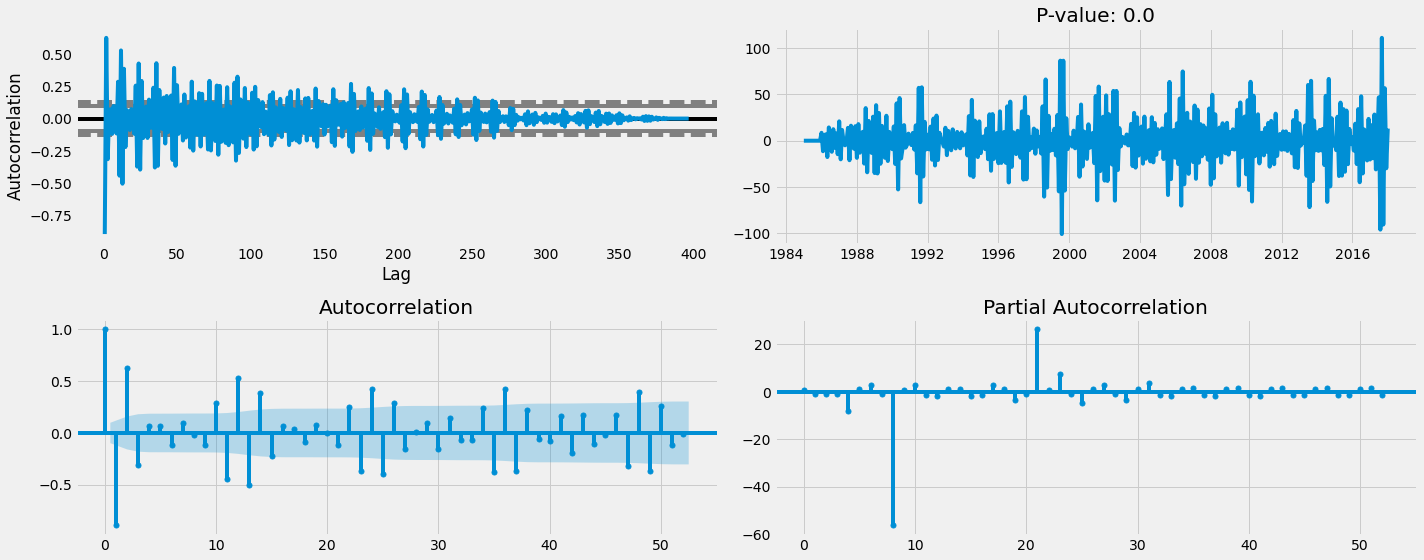

In [20]:
#Теперь по тесту Фтюлера ряд стационарен, колеблится вокруг нуля и с меньшим значеним лагов
df['Value_diff'] = np.append([0]*12, np.diff(df['Value_log'], 12))
stat_all_corr(df['Value_diff'], lags=52)

### Modeling

* 𝑃  - the order of the autoregression model for the seasonal component is also determined by the PACF, only you need to look at the number of significant lags that are multiples of the seasonality period, for example, if the period is 24 and it turns out that the 24th and 48th lags are significant by the PACF, then for the initial approximation we can take 𝑃=2
* 𝑄 - similarly, but for the model of the moving average for the seasonal component, it is determined by the ACF (4)
* 𝐷 - the order of seasonal integration of the time series. It can be either 0 or 1, since seasonal differentiation was either performed or not(1)
* I - this value is determined based on the lag value selected during differentiation. (1)
* S - this letter is responsible for seasonality and is equal to the length of the seasonality period in the time series (12)

In [21]:
X_train = df['Value_diff'].iloc[:round(len(df)*0.8)]
y_test = df['Value_diff'].iloc[round(len(df)*0.8):]

In [22]:
model = pm.auto_arima(X_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=4, max_q=4, 
                      m=12,             
                      d=1,           
                      seasonal=12,   
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3259.912, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2709.391, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2750.416, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2651.769, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2623.075, Time=2.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2629.412, Time=1.02 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2620.934, Time=3.01 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=2621.869, Time=1.90 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=3165.412, Time=3.80 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=2255.136, Time=4.50 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=2256.107, Time=3.26 sec
 ARIMA(2,1,0)(1,1,1)[12]          

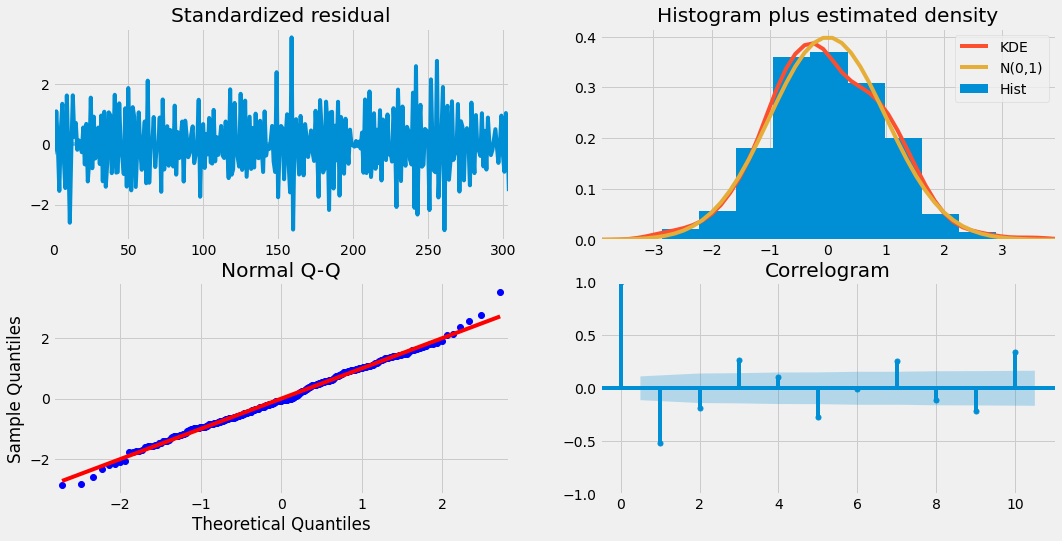

In [23]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

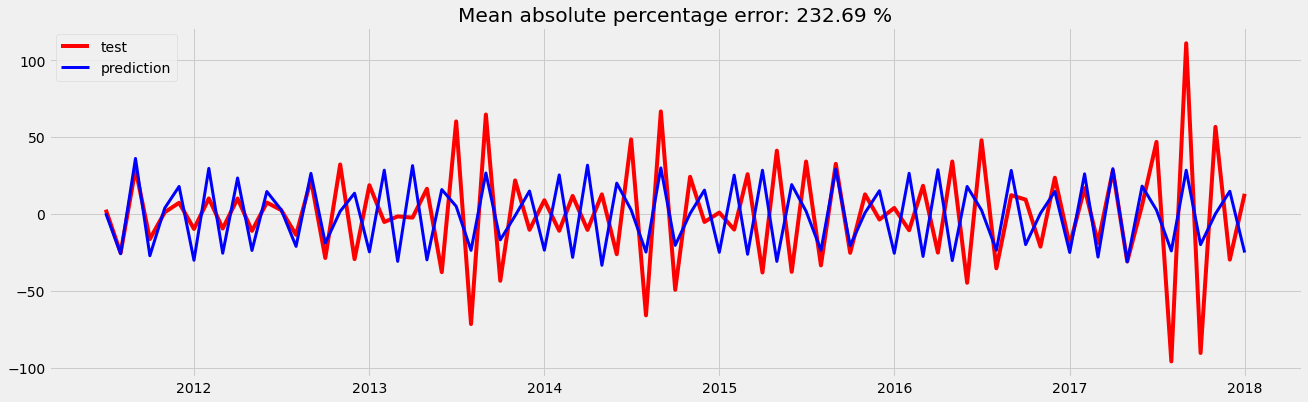

In [24]:
#ARIMA failed(
predict = model.predict(len(y_test))
plotModelResults(y_test, prediction=predict, model=model)

In [25]:
#Saving the best model
import pickle
filename = 'ts_lasso.sav'
pickle.dump(lasso, open(filename, 'wb'))